In [360]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import numpy as np
from scipy.signal import find_peaks



In [361]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [362]:
# CUDA initialization and reproducible randomization
seed = 0

np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.synchronize()

print(f"CUDA available: {torch.cuda.is_available()}, seed set to {seed}")

CUDA available: False, seed set to 0


In [363]:
import gc
import torch

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [364]:
# Initialize the model and move it to the device
model = sbm.PhaseNet.from_pretrained("stead")
model.to(device)


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [365]:
# Load the model
def load_model(model, model_filename, device):
    """
    Load the model from a file.
    Args:
        model: Model architecture to load the weights into.
        model_filename: Filename of the saved model.
        device: Device to load the model onto.
    Returns:
        Model with loaded weights.
    """
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    return model


In [366]:
# Load the final model
model_filename = "best_model.pth"

try:
    if not os.path.exists(model_filename):
        raise FileNotFoundError(
            f"Model file not found: {model_filename}. Please check the path or provide the correct model file."
        )

    print(f"✓ [Model Load]: Start - Loading weights from {model_filename}")
    model = load_model(model, model_filename, device)
    print("✓ [Model Load]: Success - Model loaded.")
except FileNotFoundError as exc:
    print(f"✗ [Model Load]: Error - {exc}")
    raise
except RuntimeError as exc:
    print("✗ [Model Load]: Error - State dict mismatch or corrupted file.")
    print(f"  Details: {exc}")
    raise
except Exception as exc:
    print("✗ [Model Load]: Error - Unexpected failure during model load.")
    print(f"  Details: {exc}")
    raise


✓ [Model Load]: Start - Loading weights from best_model.pth
✓ [Model Load]: Success - Model loaded.


In [367]:
# Load the data
try:
    # Start dataset load with explicit dataset name for logs
    print("✓ [Data Load]: Start - OKLA_1Mil_120s_Ver_3")
    # Instantiate the dataset (downloads/refreshes if needed)
    data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True)
    # Confirm successful load
    print("✓ [Data Load]: Success - Dataset loaded.")
except Exception as exc:
    # Report and propagate any failure during dataset load
    print("✗ [Data Load]: Error - Failed to load dataset.")
    print(f"  Details: {exc}")
    raise


✓ [Data Load]: Start - OKLA_1Mil_120s_Ver_3


2026-02-03 11:20:05,417 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


✓ [Data Load]: Success - Dataset loaded.


In [368]:
# Load configuration file
import json

config_path = "config.json"
config = {}

try:
    if os.path.exists(config_path):
        with open(config_path, "r") as f:
            config = json.load(f)
        print(f"✓ [Config]: Loaded from {config_path}")
    else:
        print(f"✗ [Config]: Not found - will use defaults")
except Exception as exc:
    print(f"✗ [Config]: Error - {exc}")
    config = {}



✓ [Config]: Loaded from config.json


In [369]:
# magnitude filtering (with defaults)
min_magnitude = config.get('data_filter', {}).get('min_magnitude', -1.0)
max_magnitude = config.get('data_filter', {}).get('max_magnitude', 10.0)

try:
    # Filter events with magnitude above the minimum
    print(f"✓ [Data Filter]: Start - magnitude > {min_magnitude}")
    mask = data.metadata["source_magnitude"] > min_magnitude
    data.filter(mask)
    print(f"✓ [Data Filter]: Applied - magnitude > {min_magnitude}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply minimum magnitude filter.")
    print(f"  Details: {exc}")
    raise

try:
    # Filter events with magnitude below the maximum
    print(f"✓ [Data Filter]: Start - magnitude < {max_magnitude}")
    mask = data.metadata["source_magnitude"] < max_magnitude
    data.filter(mask)
    print(f"✓ [Data Filter]: Applied - magnitude < {max_magnitude}")
except Exception as exc:
    print("✗ [Data Filter]: Error - Failed to apply maximum magnitude filter.")
    print(f"  Details: {exc}")
    raise

✓ [Data Filter]: Start - magnitude > 3.0
✓ [Data Filter]: Applied - magnitude > 3.0
✓ [Data Filter]: Start - magnitude < 4.0
✓ [Data Filter]: Applied - magnitude < 4.0


In [370]:
# set this into training
train, dev, test = data.train_dev_test()

In [371]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [372]:
# Create the output folder
output_folder = "single_examples"
os.makedirs(output_folder, exist_ok=True)

# Parameters for peak detection (with defaults)
sampling_rate = config.get('peak_detection', {}).get('sampling_rate', 100)
height = config.get('peak_detection', {}).get('height', 0.5)
distance = config.get('peak_detection', {}).get('distance', 100)

print(f"✓ [Peak Detection]: sampling_rate={sampling_rate} Hz, height={height}, distance={distance}")


✓ [Peak Detection]: sampling_rate=100 Hz, height=0.5, distance=100


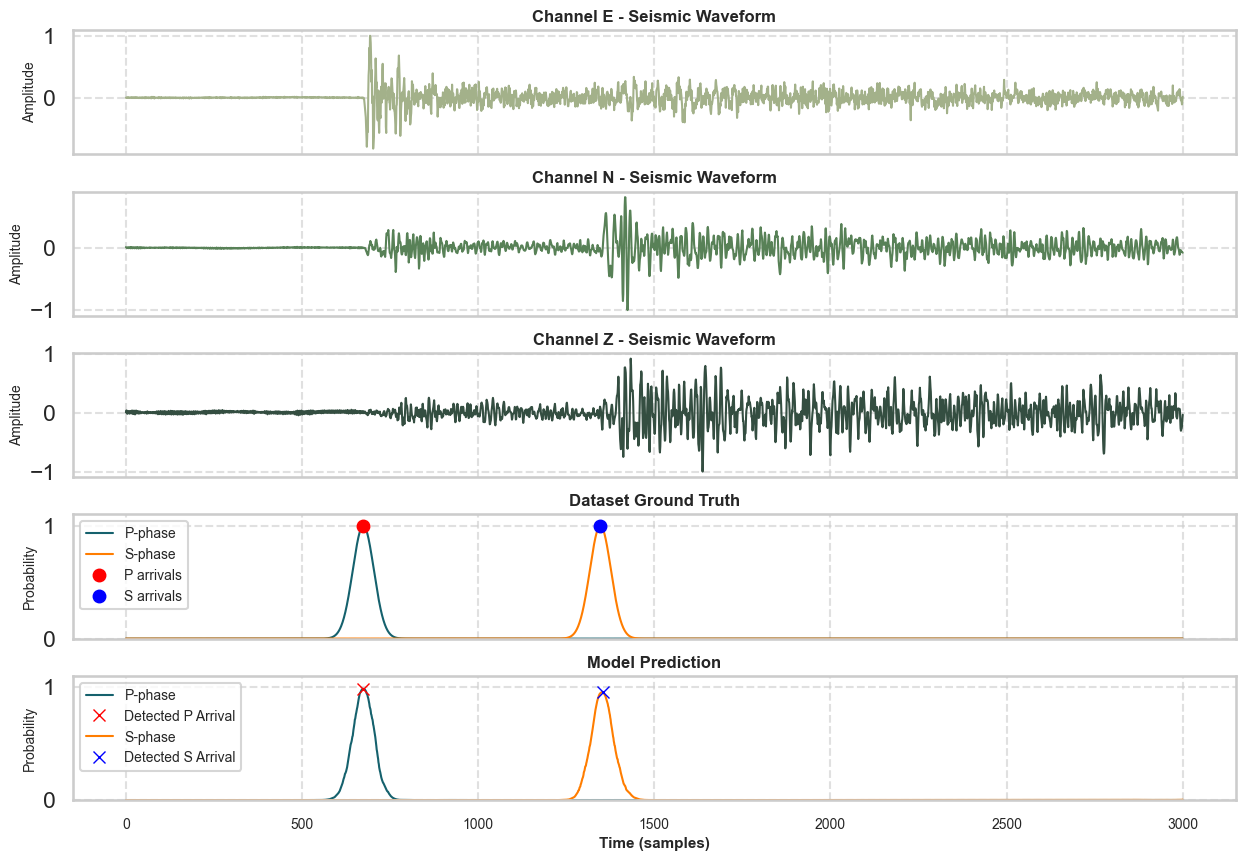

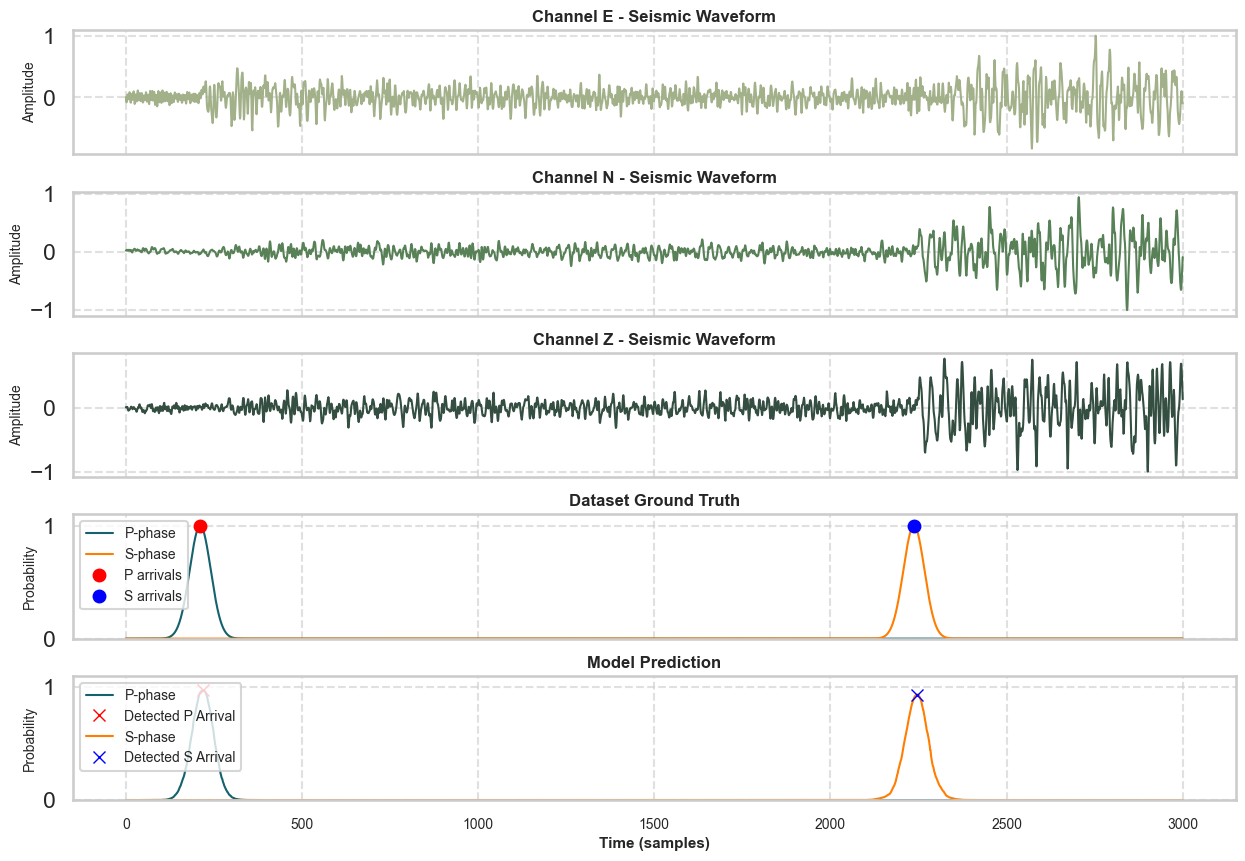

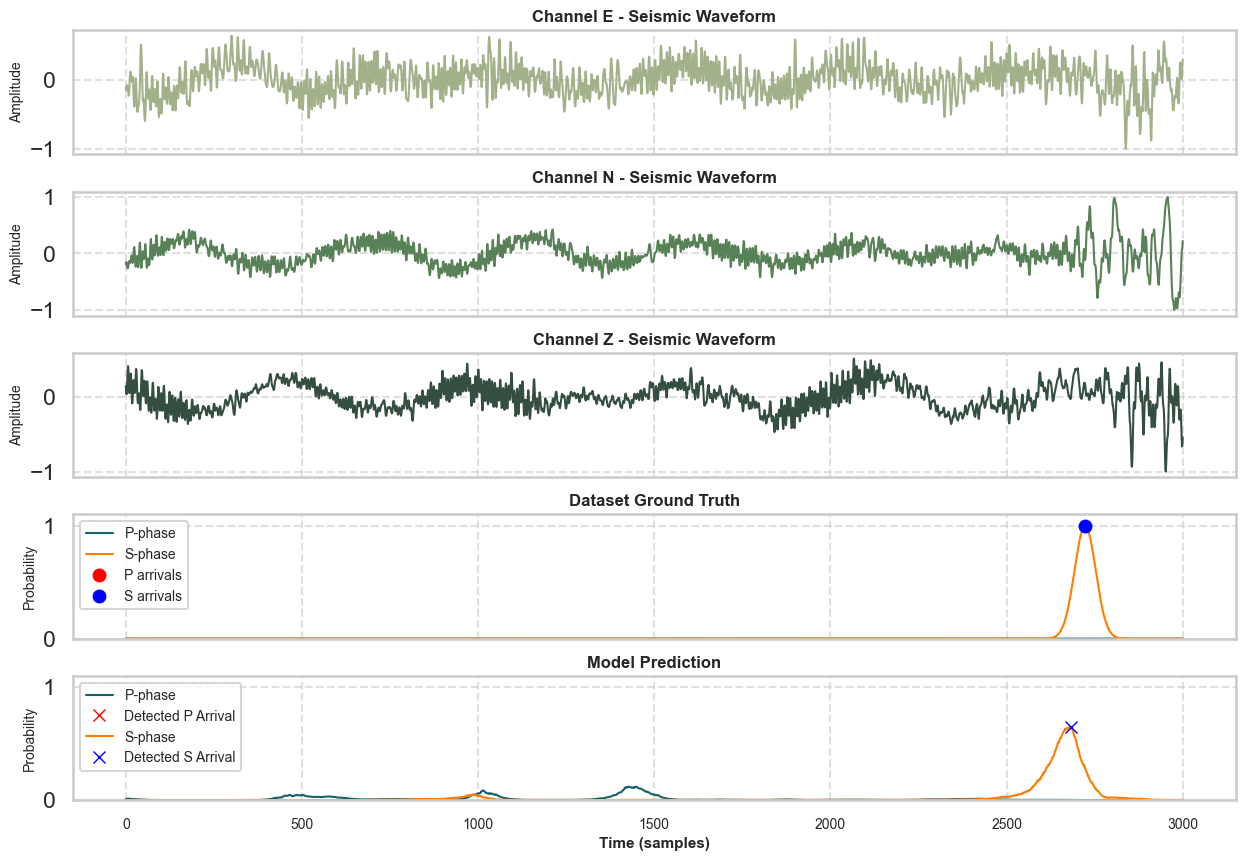

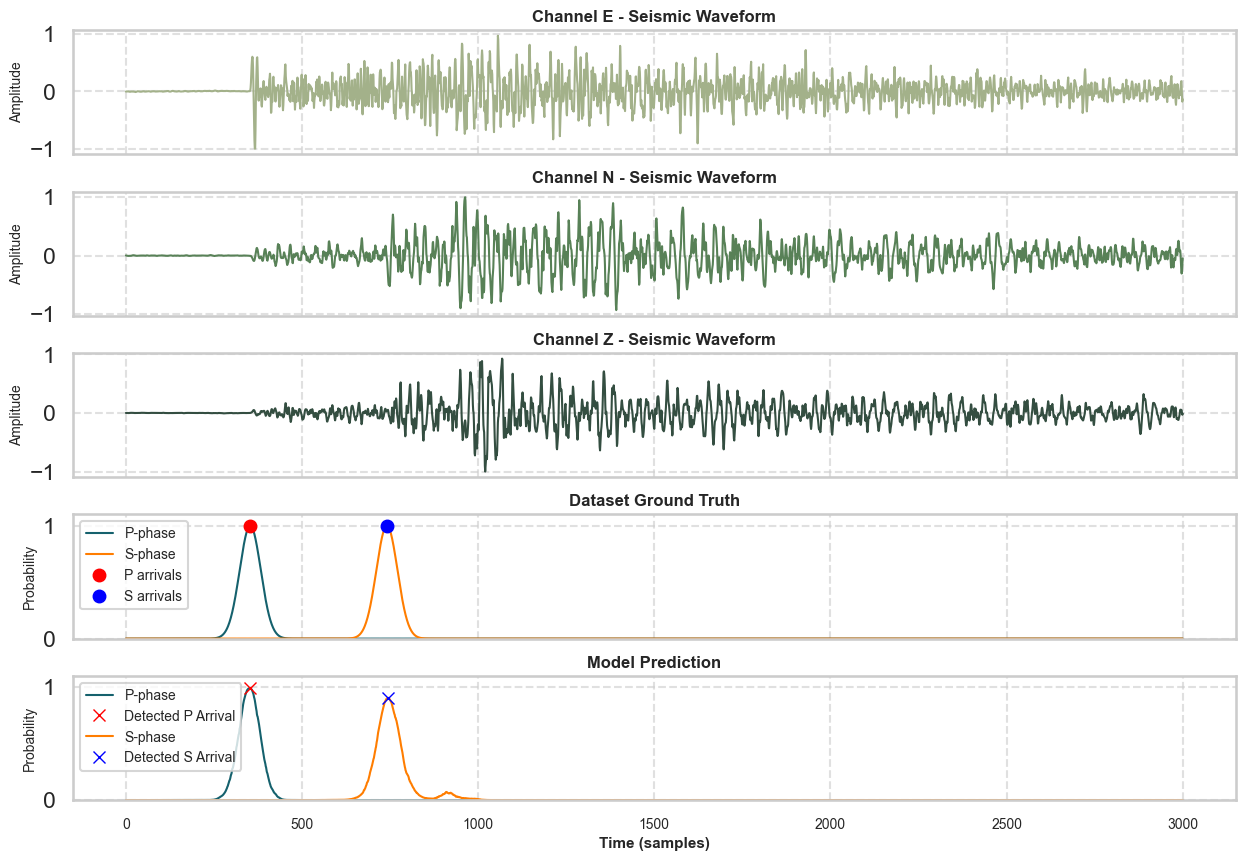

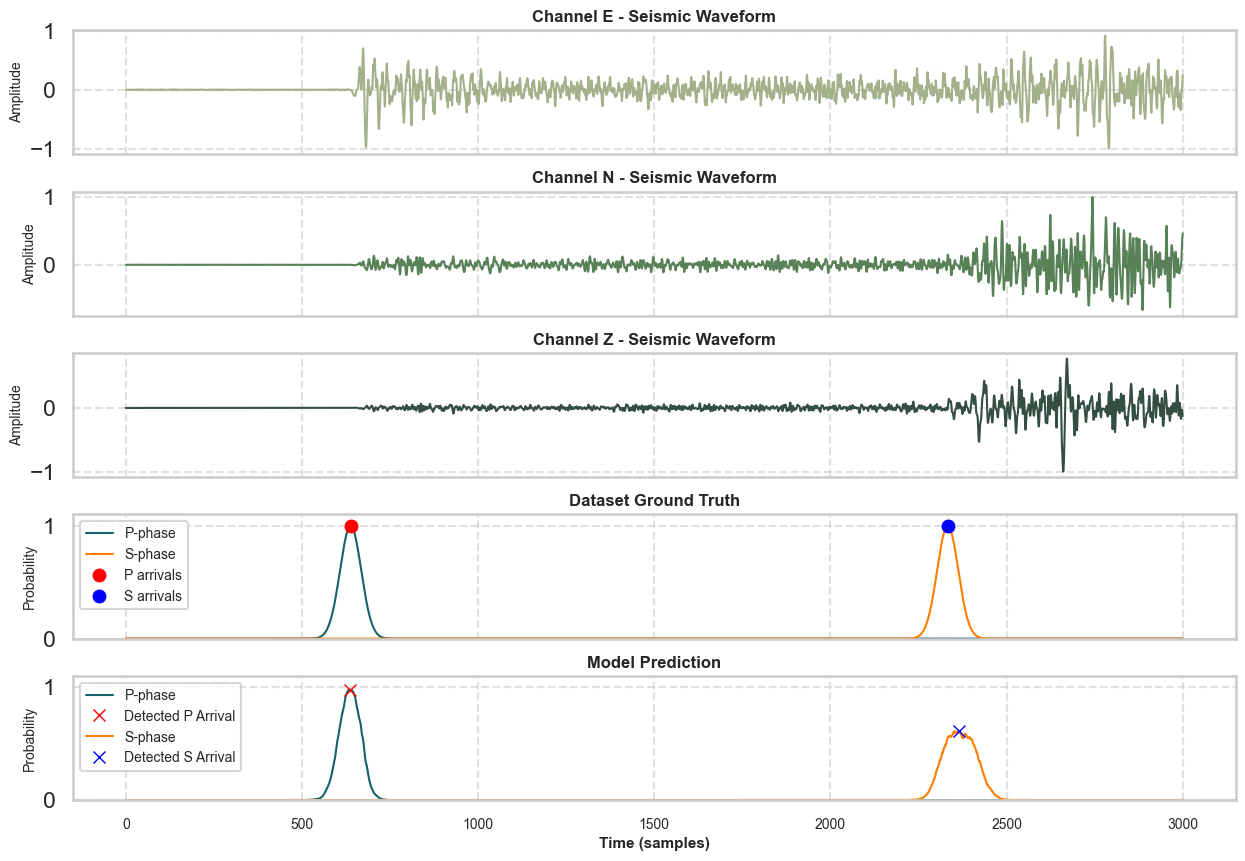

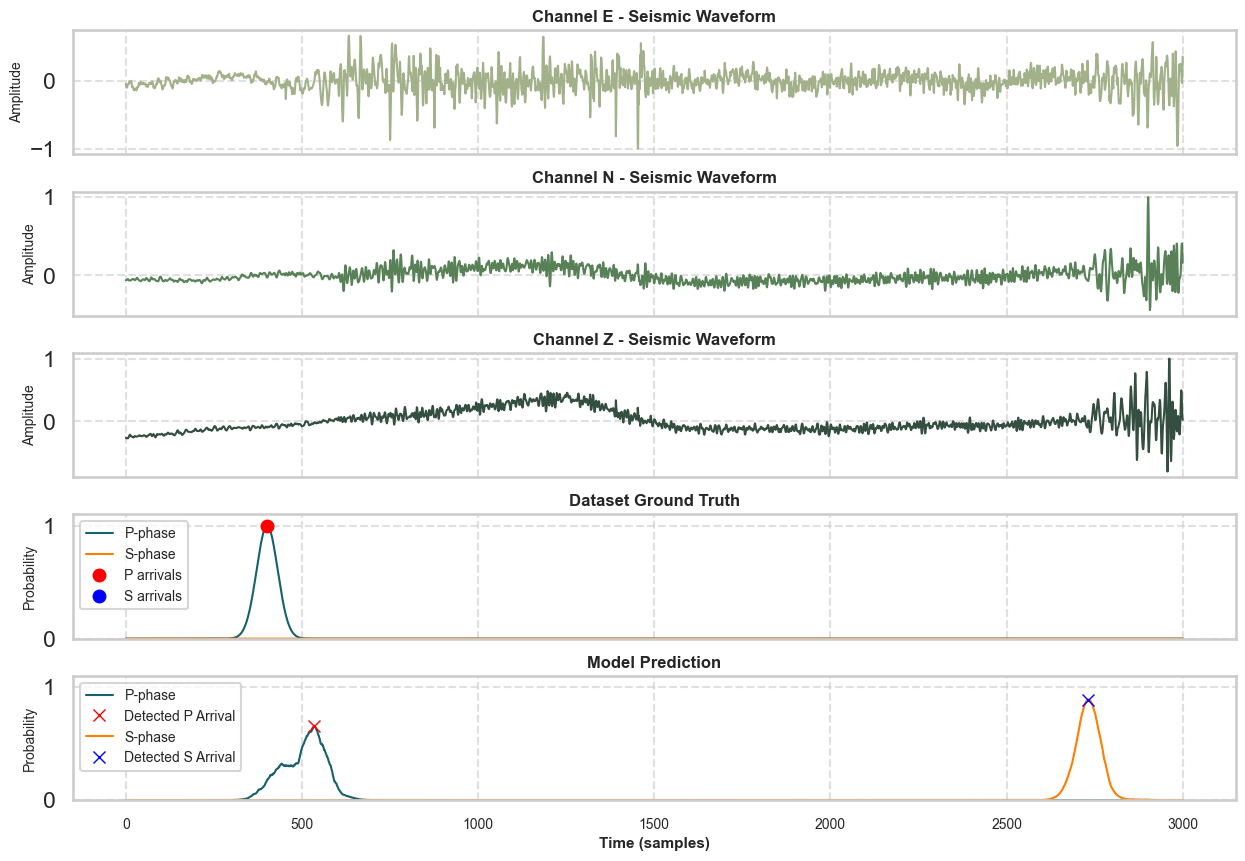

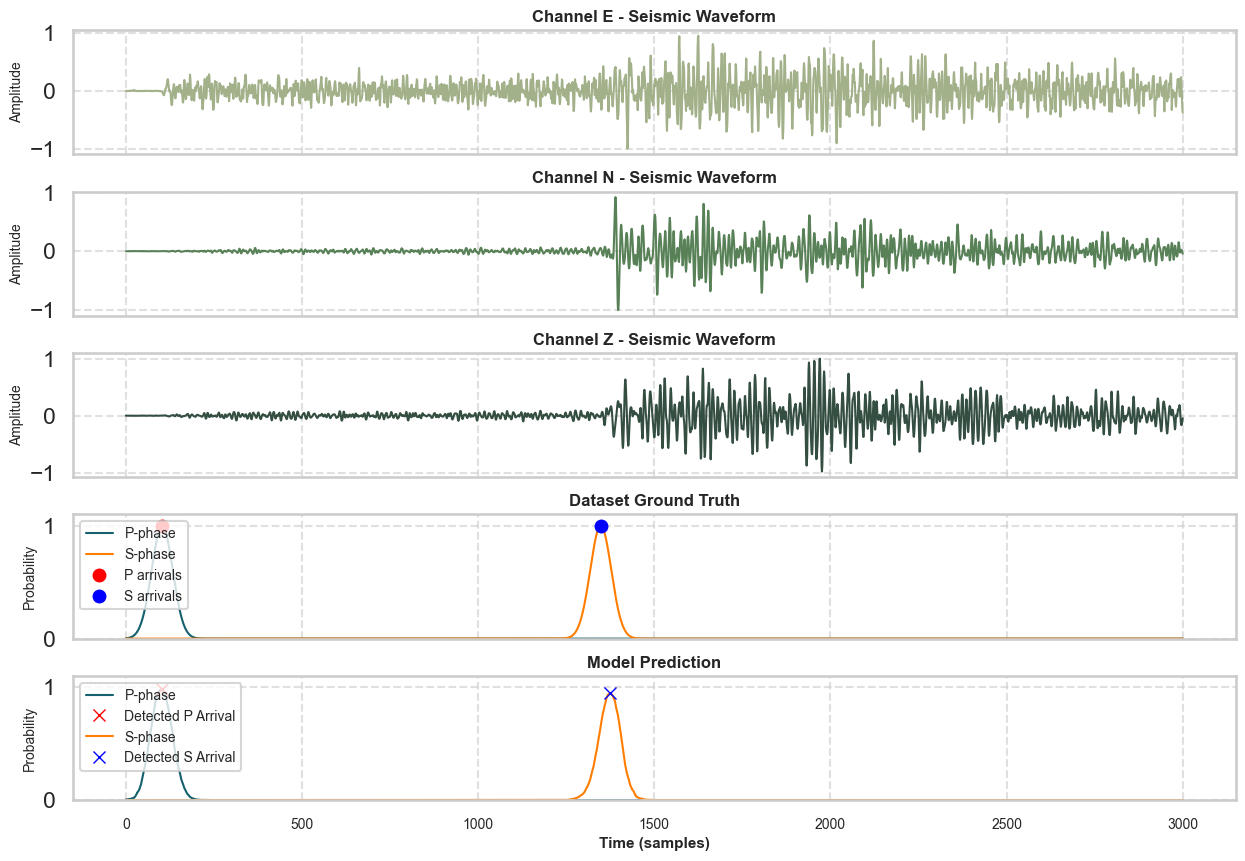

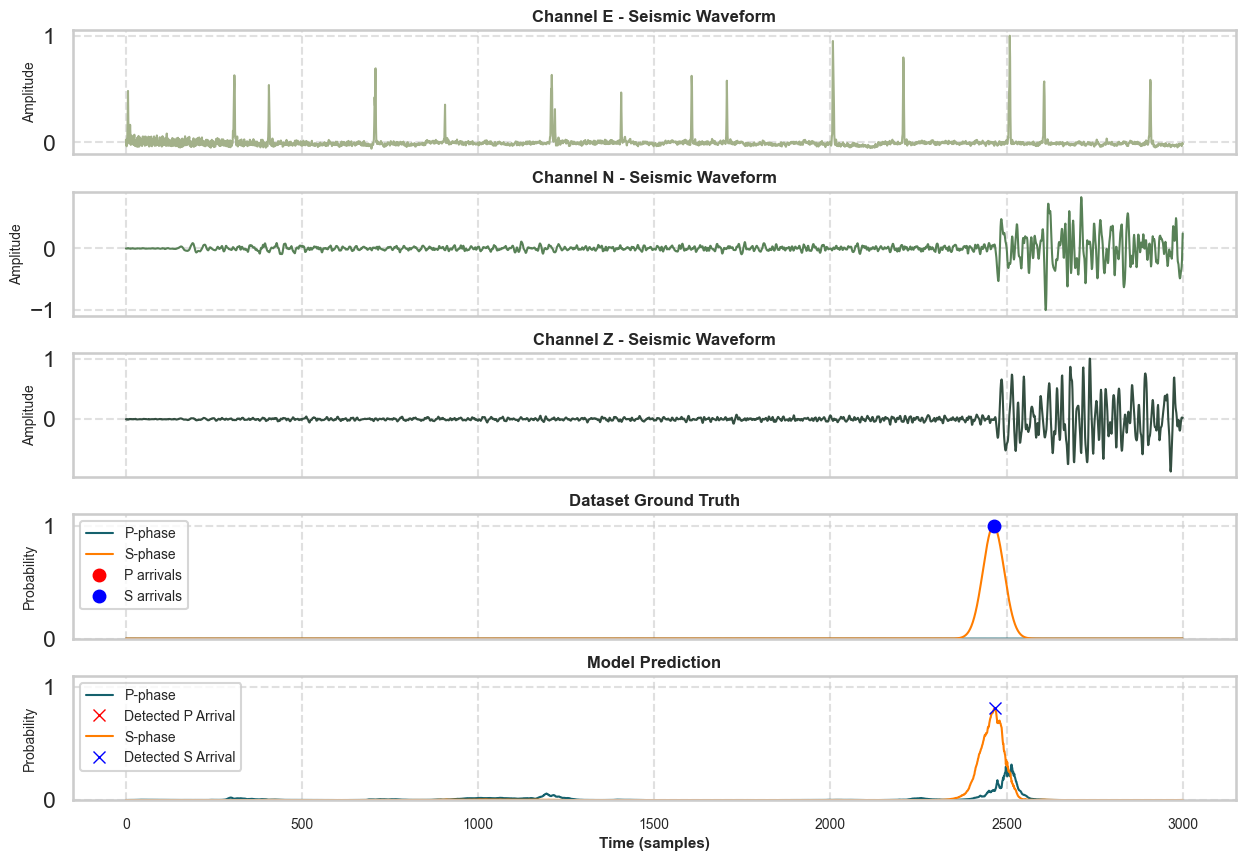

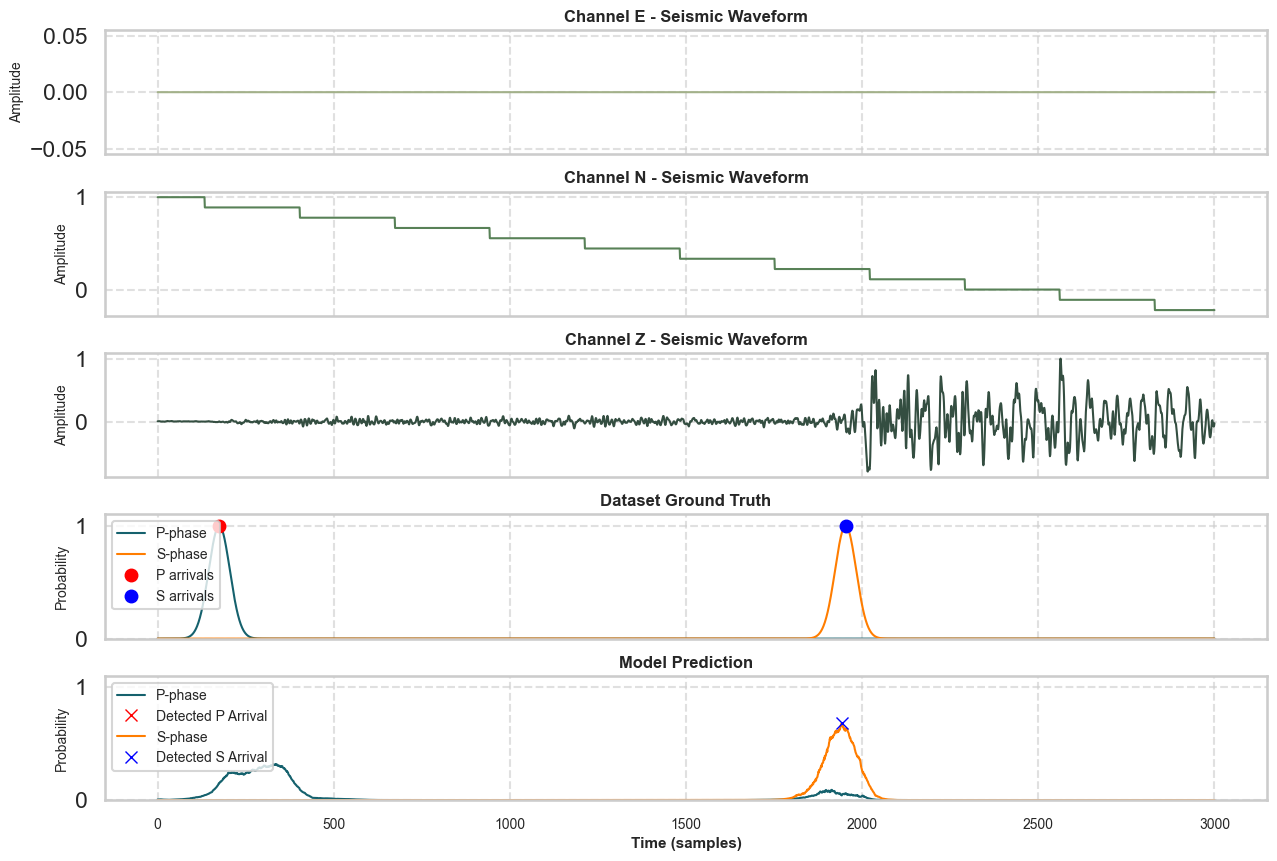

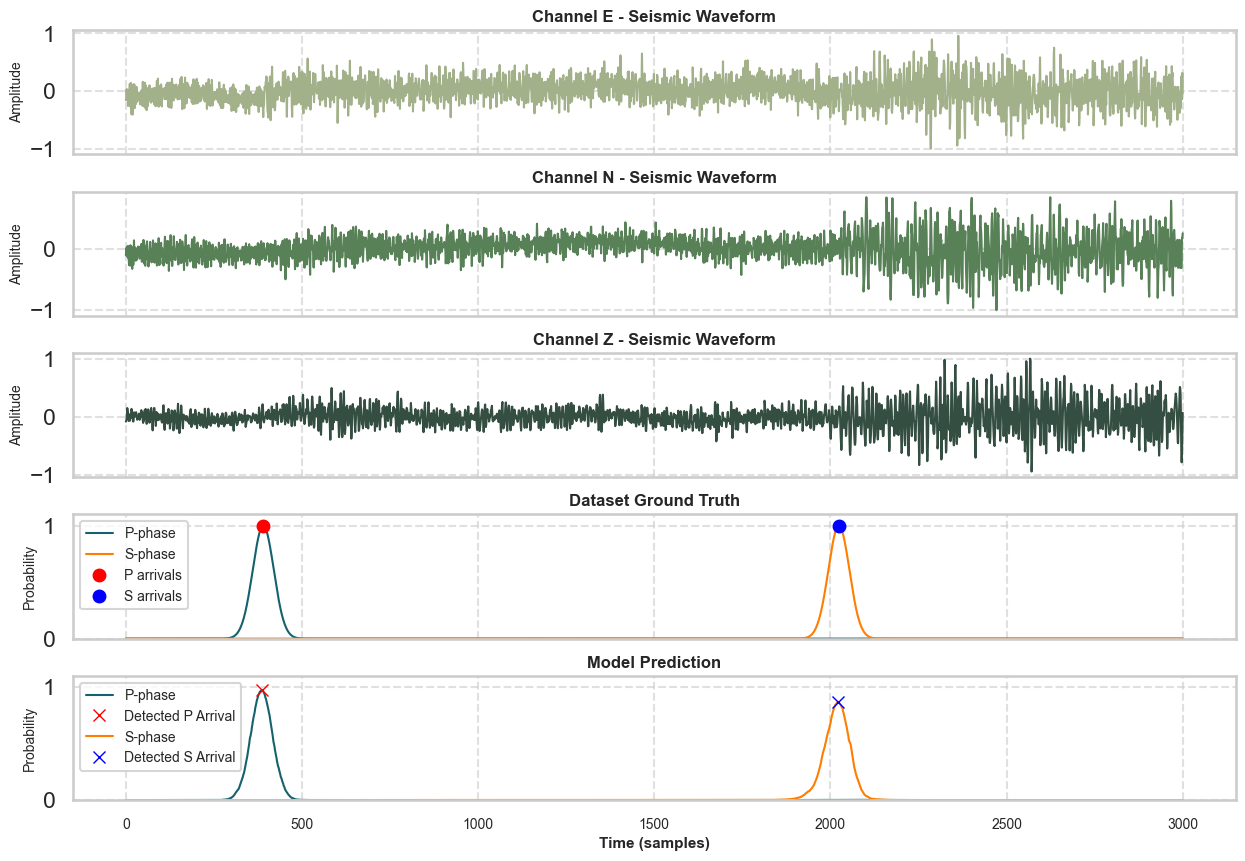

In [373]:
# Run the prediction 10 times
for i in range(1, 11):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend(fontsize=10, loc="upper left")

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Plot.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Model Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Model Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Data Sampling Rate: {sampling_rate}\n")
        f.write(f"Detection Height Parameter: {height}\n")
        f.write(f"Detection Distance Parameter: {distance}\n")


In [ ]:
# Run the prediction 10 times
for i in range(1, 11):
    # Visualizing Predictions
    sample = test_generator[np.random.randint(len(test_generator))]

    waveform = sample["X"]  # Shape: (3, N)
    labels = sample["y"]  # Shape: (3, N)

    time_axis = np.arange(waveform.shape[1])  # Create a time axis

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(5, 1, sharex=True, gridspec_kw={"hspace": 0.3})

    # Color setup
    channel_names = ["Channel E", "Channel N", "Channel Z"]
    waveform_colors = ['#a3b18a', '#588157', '#344e41']  # Custom colors for channels
    label_colors = ['#15616d', '#ff7d00']

    # Plot waveforms
    for j in range(3):
        axs[j].plot(time_axis, waveform[j], color=waveform_colors[j], linewidth=1.5)
        axs[j].set_title(f"{channel_names[j]} - Seismic Waveform", fontsize=12, fontweight='bold')
        axs[j].set_ylabel("Amplitude", fontsize=10)
        axs[j].grid(True, linestyle='--', alpha=0.6)
    
    #axs[0].plot(sample["X"].T)
    #axs[1].plot(sample["y"].T)

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Convert ground truth peak indices to time values
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    axs[3].plot(time_axis, labels[0], color=label_colors[0], linewidth=1.5, label="P-phase")
    axs[3].plot(time_axis, labels[1], color=label_colors[1], linewidth=1.5, label="S-phase")
    axs[3].plot(y_p_peaks, sample["y"][0, y_p_peaks], 'o', label='P arrivals', color='red')
    axs[3].plot(y_s_peaks, sample["y"][1, y_s_peaks], 'o', label='S arrivals', color='blue')
    axs[3].set_title("Dataset Ground Truth", fontsize=12, fontweight='bold')
    axs[3].set_ylim(0,1.1)
    axs[3].set_ylabel("Probability", fontsize=10)
    axs[3].grid(True, linestyle='--', alpha=0.6)
    axs[3].legend(fontsize=10, loc="upper left")
    
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals
    residual_p_arrival_times = p_arrival_times - y_p_arrival_times[:, np.newaxis]
    residual_s_arrival_times = s_arrival_times - y_s_arrival_times[:, np.newaxis]

    # Plot the probability distributions and the detected peaks
    axs[4].plot(p_prob, color=label_colors[0], linewidth=1.5,label='P-phase')
    axs[4].plot(p_peaks, p_prob[p_peaks], 'x', label='Detected P Arrival', color='red')
    axs[4].plot(s_prob, color=label_colors[1], linewidth=1.5,label='S-phase')
    axs[4].plot(s_peaks, s_prob[s_peaks], 'x', label='Detected S Arrival', color='blue')
    axs[4].set_title('Model Prediction', fontsize=12, fontweight='bold')
    axs[4].set_ylim(0,1.1)
    axs[4].grid(True, linestyle='--', alpha=0.6)
    axs[4].set_ylabel('Probability', fontsize=10)
    axs[4].legend(fontsize=10, loc="upper left")

    # Improve x-axis visibility
    axs[4].set_xlabel("Time (samples)", fontsize=11, fontweight='bold')
    axs[4].tick_params(axis='x', labelsize=10)

    #plt.tight_layout()
    plot_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Plot.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

    # Save the results to a text file
    results_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Results.txt")
    with open(results_filename, "w") as f:
        f.write(f"Ground Truth P arrival times: {y_p_arrival_times}\n")
        f.write(f"Ground Truth S arrival times: {y_s_arrival_times}\n")
        f.write(f"Model Predicted P arrival times: {p_arrival_times}\n")
        f.write(f"Model Predicted S arrival times: {s_arrival_times}\n")
        f.write(f"Residual P arrival times: {residual_p_arrival_times}\n")
        f.write(f"Residual S arrival times: {residual_s_arrival_times}\n")

    # Save the parameters to a text file
    parameters_filename = os.path.join(output_folder, f"Okla_Model_Pred_{i:03d}_Parameters.txt")
    with open(parameters_filename, "w") as f:
        f.write(f"Data Sampling Rate: {sampling_rate}\n")
        f.write(f"Detection Height Parameter: {height}\n")
        f.write(f"Detection Distance Parameter: {distance}\n")


Total ground truth P peaks: 952
Total ground truth S peaks: 870
Total P-phase residuals under 0.6s: 933
Total S-phase residuals under 0.6s: 713
P-phase Residuals: Mean = 0.0050, Std = 0.2087
Total detected P picks: 941


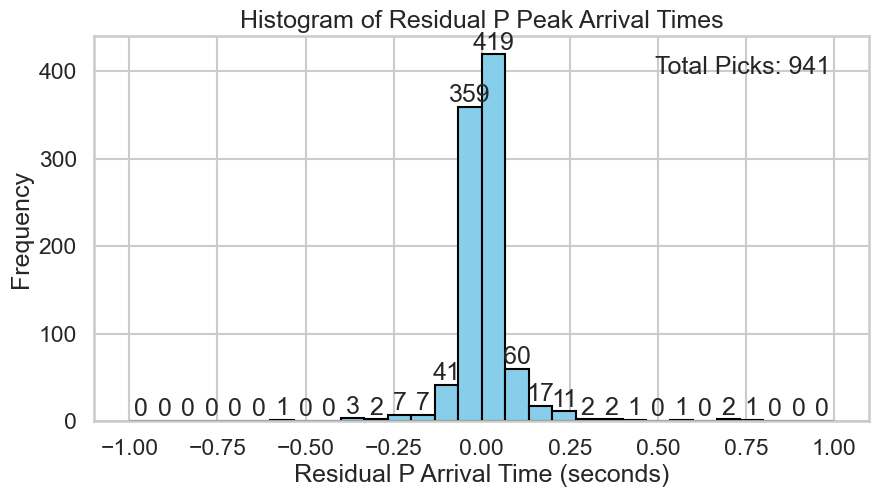

S-phase Residuals: Mean = 0.0938, Std = 1.0453
Total detected S picks: 734


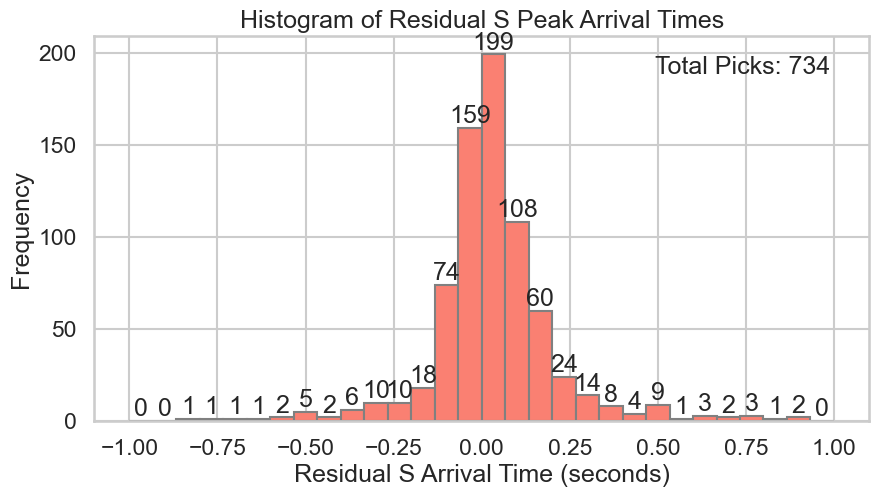

In [374]:

#n_samples = len(test_generator)

n_samples = int(0.1 * len(test_generator))

all_residual_p_arrival_times = []
all_residual_s_arrival_times = []

# Initialize counters for ground truth P and S labels
groundtruth_p_peaks = 0
groundtruth_s_peaks = 0

# Initialize counters for residuals smaller than 0.6 (absolute value)
count_residuals_p_under_0_6 = 0
count_residuals_s_under_0_6 = 0

# Only Commenting this out to reflect the randome samples to squential samples 

for i in range(n_samples):
#for i in range(len(test_generator)):
    
    # Hongyu Xiao: randome sample works effectively
    sample = test_generator[np.random.randint(len(test_generator))]

    #sample = test_generator[i]

    # Find peaks in the ground truth labels
    y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
    y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)

    # Update the counters
    groundtruth_p_peaks += len(y_p_peaks)
    groundtruth_s_peaks += len(y_s_peaks)

    # Convert ground truth peak indices to time values
    sampling_rate = 100  # Samples per second (100 Hz)
    y_p_arrival_times = y_p_peaks / sampling_rate
    y_s_arrival_times = y_s_peaks / sampling_rate

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    # Extract the probability distributions for P and S phases
    p_prob = pred[0]
    s_prob = pred[1]

    # Identify peaks in the probability distributions
    p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
    s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)

    # Convert peak indices to time values
    p_arrival_times = p_peaks / sampling_rate
    s_arrival_times = s_peaks / sampling_rate

    # Calculate residuals for P and S peaks, keeping only the smallest one by absolute value
    for y_p_time in y_p_arrival_times:
        residual_p_arrival_times = p_arrival_times - y_p_time
        if len(residual_p_arrival_times) > 0:
            min_residual_p = residual_p_arrival_times[np.argmin(np.abs(residual_p_arrival_times))]
            all_residual_p_arrival_times.append(min_residual_p)
            if np.abs(min_residual_p) < 0.6:
                count_residuals_p_under_0_6 += 1
        
    for y_s_time in y_s_arrival_times:
        residual_s_arrival_times = s_arrival_times - y_s_time
        if len(residual_s_arrival_times) > 0:
            min_residual_s = residual_s_arrival_times[np.argmin(np.abs(residual_s_arrival_times))]
            all_residual_s_arrival_times.append(min_residual_s)
            if np.abs(min_residual_s) < 0.6:
                count_residuals_s_under_0_6 += 1

# Display the total counts of ground truth P and S peaks
print(f"Total ground truth P peaks: {groundtruth_p_peaks}")
print(f"Total ground truth S peaks: {groundtruth_s_peaks}")

# Display the counts of residuals under 0.6 seconds
print(f"Total P-phase residuals under 0.6s: {count_residuals_p_under_0_6}")
print(f"Total S-phase residuals under 0.6s: {count_residuals_s_under_0_6}")

# Plot the histogram of residual P peak arrival times
plt.figure(figsize=(10, 5))
counts_p, bins_p, patches_p = plt.hist(all_residual_p_arrival_times, bins=30, color='skyblue', edgecolor='black', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_p, bins_p, patches_p):
    plt.text(bin_ + (bins_p[1] - bins_p[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_p = len(all_residual_p_arrival_times)
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_p}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"P-phase Residuals: Mean = {mean_p:.4f}, Std = {std_p:.4f}")
print(f"Total detected P picks: {total_picks_p}")

plt.title('Histogram of Residual P Peak Arrival Times')
plt.xlabel('Residual P Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("residual_p_histogram.png")  # Save the figure as a PNG file
plt.show()

# Plot the histogram of residual S peak arrival times
plt.figure(figsize=(10, 5))
counts_s, bins_s, patches_s = plt.hist(all_residual_s_arrival_times, bins=30, color='salmon', edgecolor='grey', range=(-1, 1))

# Add labels for the number counts on each column
for count, bin_, patch in zip(counts_s, bins_s, patches_s):
    plt.text(bin_ + (bins_s[1] - bins_s[0]) / 2, count, f'{int(count)}', ha='center', va='bottom')

# Print total pick count, mean, and standard deviation
total_picks_s = len(all_residual_s_arrival_times)
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
plt.text(0.95, 0.95, f'Total Picks: {total_picks_s}', ha='right', va='top', transform=plt.gca().transAxes)
print(f"S-phase Residuals: Mean = {mean_s:.4f}, Std = {std_s:.4f}")
print(f"Total detected S picks: {total_picks_s}")

plt.title('Histogram of Residual S Peak Arrival Times')
plt.xlabel('Residual S Arrival Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("residual_s_histogram.png")  # Save the figure as a PNG file
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


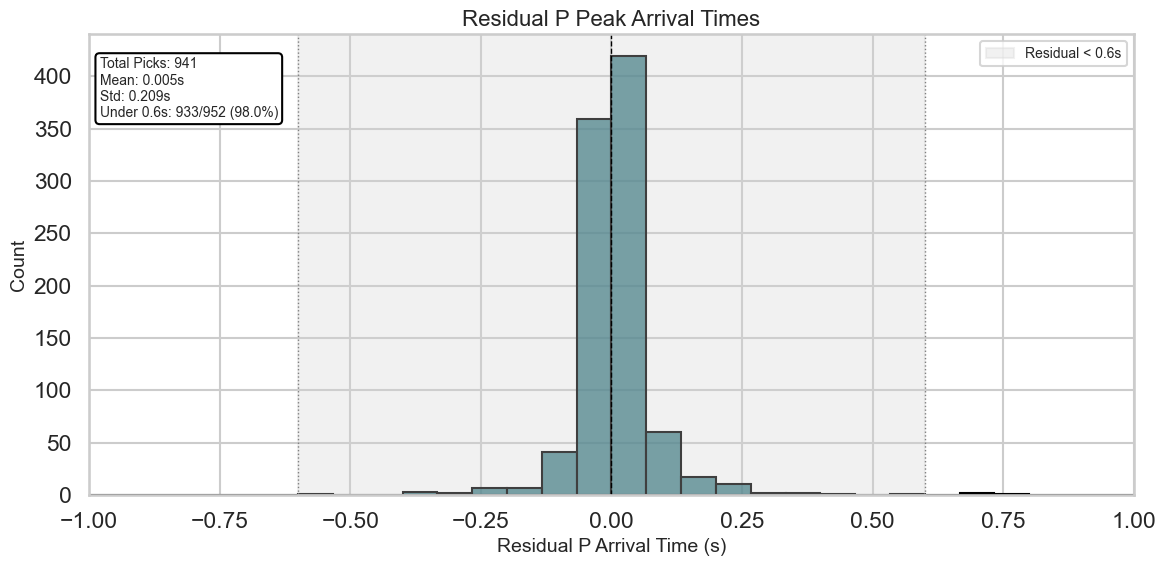

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


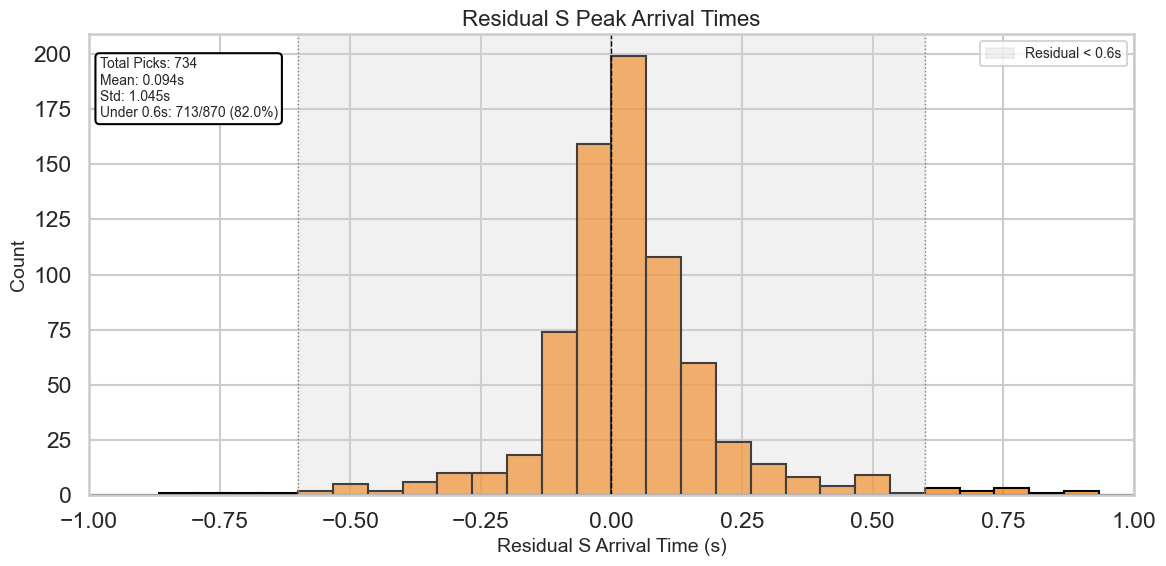

In [375]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Parameters
x_min, x_max = -1, 1
bins = np.linspace(x_min, x_max, 31)  # 30 bins between -1 and 1

# Custom colors
p_color = '#15616d'
s_color = '#ff7d00'
shading_color = '#d3d3d3'  # light gray for shaded success zone

# === P-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_p_arrival_times, bins=bins, kde=False, color=p_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_p = np.mean(all_residual_p_arrival_times)
std_p = np.std(all_residual_p_arrival_times)
total_picks_p = len(all_residual_p_arrival_times)
fraction_p = count_residuals_p_under_0_6 / groundtruth_p_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_p}\nMean: {mean_p:.3f}s\nStd: {std_p:.3f}s\nUnder 0.6s: {count_residuals_p_under_0_6}/{groundtruth_p_peaks} ({fraction_p:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual P Peak Arrival Times', fontsize=16)
plt.xlabel('Residual P Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("residual_p_histogram_shaded.png")
plt.savefig("residual_p_histogram_shaded.ps")
plt.show()


# === S-phase residuals ===
plt.figure(figsize=(12, 6))
sns.histplot(all_residual_s_arrival_times, bins=bins, kde=False, color=s_color, edgecolor='black', stat='count')

# Shaded ±0.6s zone
plt.axvspan(-0.6, 0.6, color=shading_color, alpha=0.3, label='Residual < 0.6s')

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(-0.6, color='gray', linestyle=':', linewidth=1)
plt.axvline(0.6, color='gray', linestyle=':', linewidth=1)

# Stats and annotation
mean_s = np.mean(all_residual_s_arrival_times)
std_s = np.std(all_residual_s_arrival_times)
total_picks_s = len(all_residual_s_arrival_times)
fraction_s = count_residuals_s_under_0_6 / groundtruth_s_peaks

plt.text(x_min + 0.02, plt.gca().get_ylim()[1]*0.95,
         f'Total Picks: {total_picks_s}\nMean: {mean_s:.3f}s\nStd: {std_s:.3f}s\nUnder 0.6s: {count_residuals_s_under_0_6}/{groundtruth_s_peaks} ({fraction_s:.1%})',
         ha='left', va='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))

plt.title('Residual S Peak Arrival Times', fontsize=16)
plt.xlabel('Residual S Arrival Time (s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(x_min, x_max)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("residual_s_histogram_shaded.png")
plt.savefig("residual_s_histogram_shaded.ps")
plt.show()
